## 一、区域人口计算
城市地区的人口流动性较强，难以直接获得某一个特定较小区域内的人口数，并且常住人口分布难以体现城市的人口流动性。所以，我们尝试将到达一个区域的行程次数视为该区域的人口（可以理解为该城市某一特定区域实际的平均每日人口），它与实际的平均每日人口大致成正比$^{[1]}$。它可能能较好的反应该区域的活动强度。

[1] Liang Xiao, Zhao Jichang, Dong Li and Xu Ke. 2013. Unraveling the Origin of Exponential Law in Intra-Urban Human Mobility. Scientific Reports, 3: 2983.

## 二、出行流量预测

### 2.1 模型假设
首先我们作出如下假设：
* 某人到达某个区域的概率与该区域的人口密度呈正相关；
* 某人到达某个区域的概率与该区域与起始区域之间的欧几里得距离呈负相关；
又因为我们将区域划分为1km * 1km的区域，所以我们直接用某一区域的人口数作为该区域的人口密度；即：
$$
P(j | i) \propto \frac{P(j)}{f(d_{ij})}
$$
其中：
* $P(j | i)$表示人在位于区域i的条件下前往区域j的概率；（条件概率）
* $P(j)$表示区域i的人口数（Population）；
* $f(d_{ij})$表示区域i和区域j之间的距离函数，即距离衰减函数。比如$f(d) = d^\sigma$，其中$\sigma$控制距离的影响程度；

则：
$$
P(i \rightarrow j) = P(ij) = P_{norm}(i) \cdot P(j | i) = P_{norm}(i) \cdot \frac{\frac{P(j)}{f(d_{ij})}}{M(i)}
$$



### 2.2 关于$P_{norm}$
$P_{norm}(i)$表示从区域i发起行程的可能性：
$$
P_{norm}(i) = \frac{O(i)}{\sum_k O(k)}
$$
其中：
* $O(i)$表示区域i的出发次数；
* $\sum_k O(k)$表示所有区域出发次数的总和；

它将出行次数标准化为概率分布，即：
$$
\sum_i P_{norm}(i) = 1
$$

### 2.3 关于$M(i)$
$M(i)$的作用也是将从区域i出发前往其他区域的概率归一化：
$$
M(i) = \sum_{k \ne i} \frac{P(k)}{f(d_{ik})}
$$
其中：
* $P(k)$表示区域k作为目的地的到达次数；
* $f(d_{ik})$为区域i和k之间距离的函数；

不难推出：
$$
\sum_{j \ne i} \frac{\frac{P(j)}{f(d_{ij})}}{M(i)} = 1
$$

### 2.4 关于距离衰减函数
如果距离衰减函数用幂律形式$f(d) = d^\sigma$，则：
* 当$\sigma > 0$时，前往某区域的概率会被距离抑制；
* 当$\sigma = 0$时，所有区域的吸引力完全由该地的人口数决定；

关于如何确定$\sigma$，可以用最大似然估计等进行参数优化。

### 2.5 出行流量预测模型

于是，我们给出完整的出行流量预测模型如下：
$$
<T_{ij}> = \frac{T}{M(i)} \cdot \frac{P_{norm}(i)\cdot P(j)}{f(d_{ij})}
$$

其中：
* $<T_{ij}>$表示从区域i到j的出行预测次数；
* $T$表示行程总数；

### 2.6 参数优化
对于如何确定$\sigma$，我们使用最大似然估计MLE来进行。

#### 2.6.1 基本假设
将城市中的出行活动视为概率事件：
1. 每个出行记录的生成是独立事件（i.e., 出行之间无相关性）；
2. 每个出行的目标选择是一个多类别随机过程：从任一区域 $i$ 出发到其他区域 $j \neq i$ 的概率由模型给出；
3. 整体出行行为遵循多项式分布；

在此假设下，总出行量 $T = \sum_{i,j} T_{ij}$ 是固定的，人从出发地到目的地的分配可看作将 $T$ 次“试验”分配至不同的路径 $i \to j$。

#### 2.6.2 似然函数：
对于 $T$ 次独立试验，若：
* 从 $i$ 到 $j$ 的路径被选择的概率为 $p_{ij} = \frac{\langle T_{ij} \rangle}{T}$（由模型预测）；
* 实际观测到 $i \to j$ 的出行次数为 $T_{ij}$；

则似然函数为：
$$
\mathcal{L} = \frac{T!}{\prod_{i,j} T_{ij}!} \prod_{i,j} \left( p_{ij} \right)^{T_{ij}}
$$

其中：
* $\prod_{i,j} \left( p_{ij} \right)^{T_{ij}}$ 表示每条路径的概率的幂次乘积；
* $\frac{T!}{\prod_{i,j} T_{ij}!}$ 是组合数（反映不同路径次数分配的可能排列方式）；

由于组合数 $\frac{T!}{\prod_{i,j} T_{ij}!}$ 是常数（与参数 $\sigma$ 无关），因此在最大化似然时可忽略。简化后的目标函数为：
$$
\mathcal{L} \propto \prod_{i,j} \left( p_{ij} \right)^{T_{ij}} = \prod_{i,j} \left( \frac{\langle T_{ij} \rangle}{T} \right)^{T_{ij}}.
$$

#### 2.6.3 负对数似然转化
实际计算时，通常优化负对数似然（NLL），因为乘积转换为求和更易处理，且可避免极小数值的浮点溢出：
$$
-\ln \mathcal{L} = \text{常数} - \sum_{i,j} T_{ij} \ln \langle T_{ij} \rangle.
$$
进一步忽略常数项后，优化问题简化为：
$$
\sigma_{\text{opt}} = \arg \min_{\sigma} \left( -\sum_{i,j} T_{ij} \ln \langle T_{ij} \rangle \right).
$$

## 三、实验过程

### 3.1 出行记录与网格匹配

In [1]:
# 相关包的导入
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, box

In [2]:
# 读取网格数据
grids = pd.read_csv('./data/grid/shanghai_grid_wgs84.csv')

# 读取行程数据
trips = pd.read_csv('./data/simplified_trips/simplified_trips.csv')

In [3]:
# 将行程数据转换为GeoDataFrame
trips['origin_point'] = trips.apply(lambda row: Point(row['x_o'], row['y_o']), axis=1)
trips['dest_point'] = trips.apply(lambda row: Point(row['x_d'], row['y_d']), axis=1)
trips_gdf = gpd.GeoDataFrame(trips, geometry='origin_point', crs="EPSG:4326")

# 将网格数据转换为GeoDataFrame
grids['geometry'] = grids.apply(lambda row: box(row['min_x'], row['min_y'], 
                              row['max_x'], row['max_y']), axis=1)
grids_gdf = gpd.GeoDataFrame(grids, geometry='geometry', crs="EPSG:4326")

In [4]:
# 创建空间索引
grids_gdf.sindex

trips_gdf['trip_id'] = range(len(trips_gdf))

# 进行起点连接
origin_joined = gpd.sjoin(trips_gdf, grids_gdf, how='inner', 
                         predicate='within', lsuffix='', rsuffix='_origin')
origin_joined = origin_joined.rename(columns={'grid_id': 'origin_grid'})

# 进行终点连接
dest_joined = gpd.sjoin(trips_gdf.set_geometry('dest_point', crs="EPSG:4326"), 
                       grids_gdf, how='inner', predicate='within', 
                       lsuffix='', rsuffix='_dest')
dest_joined = dest_joined.rename(columns={'grid_id': 'dest_grid'})

In [5]:
# 使用trip_id进行合并
filtered_trips = pd.merge(
    origin_joined[['trip_id', 'origin_grid']],
    dest_joined[['trip_id', 'dest_grid']],
    on='trip_id',
    how='inner'
)

# 将网格信息合并回原始数据
final_trips = pd.merge(
    trips_gdf,
    filtered_trips,
    on='trip_id',
    how='inner'
)

# 清理不需要的列
final_trips = final_trips[[
    'x_o', 'y_o', 'x_d', 'y_d', 'd', 
    'origin_grid', 'dest_grid'
]]

In [6]:
# 保存过滤后的轨迹数据
final_trips.to_csv('data/simplified_trips/filtered_trips_with_grid.csv', index=False)

# 获取所有网格ID
all_grids = grids_gdf['grid_id'].unique()

# 创建包含所有网格的DataFrame
all_grids_df = pd.DataFrame({'grid_id': all_grids})

# 统计网格使用情况
origin_counts = final_trips['origin_grid'].value_counts().reset_index()
origin_counts.columns = ['grid_id', 'origin_count']

dest_counts = final_trips['dest_grid'].value_counts().reset_index()
dest_counts.columns = ['grid_id', 'dest_count']

# 合并统计结果，保留所有网格
grid_stats = all_grids_df.merge(
    origin_counts, on='grid_id', how='left'
).merge(
    dest_counts, on='grid_id', how='left'
).fillna(0)

# 保存网格使用情况数据
grid_stats.to_csv('data/grid/grid_usage_statistics.csv', index=False)

# 打印保存信息
print("已保存过滤后的轨迹数据到：data/simplified_trips/filtered_trips_with_grid.csv")
print("已保存网格使用情况数据到：data/grid/grid_usage_statistics.csv")

已保存过滤后的轨迹数据到：data/simplified_trips/filtered_trips_with_grid.csv
已保存网格使用情况数据到：data/grid/grid_usage_statistics.csv


In [7]:
# 打印部分统计结果
print("网格使用情况统计（前10行）：")
print(grid_stats.head(10))

# 检查统计结果
print("\n统计结果验证：")
print(f"总起点次数: {grid_stats['origin_count'].sum()}")
print(f"总终点次数: {grid_stats['dest_count'].sum()}")
print(f"起点次数最多的网格: {grid_stats.loc[grid_stats['origin_count'].idxmax()]}")
print(f"终点次数最多的网格: {grid_stats.loc[grid_stats['dest_count'].idxmax()]}")

网格使用情况统计（前10行）：
   grid_id  origin_count  dest_count
0     6251           0.0         0.0
1     5852           0.0         0.0
2     6118           0.0         0.0
3     5985           0.0         0.0
4     5986           0.0         0.0
5     5853           0.0         0.0
6     6252           0.0         0.0
7     6119           0.0         0.0
8     5854           0.0         0.0
9     5987           0.0         0.0

统计结果验证：
总起点次数: 92002.0
总终点次数: 92002.0
起点次数最多的网格: grid_id         5909.0
origin_count    1530.0
dest_count      2382.0
Name: 3440, dtype: float64
终点次数最多的网格: grid_id         5909.0
origin_count    1530.0
dest_count      2382.0
Name: 3440, dtype: float64


In [8]:
# 统计结果
original_count = len(trips_gdf)
filtered_count = len(final_trips)
removed_count = original_count - filtered_count
retention_rate = filtered_count / original_count * 100

print(f"原始数据行数: {original_count}")
print(f"过滤后数据行数: {filtered_count}")
print(f"被过滤掉的数据行数: {removed_count}")
print(f"数据保留率: {retention_rate:.2f}%")

原始数据行数: 92292
过滤后数据行数: 92002
被过滤掉的数据行数: 290
数据保留率: 99.69%


### 3.2 数据填补
我们将上一步处理后得到的数据进行可视化呈现，使用到达次数（dest_count）作为热度图的值。

In [9]:
import numpy as np
import branca.colormap as cm
import folium

In [10]:
# 创建对数颜色映射
max_dest = grid_stats['dest_count'].max()
log_norm = cm.LinearColormap(
    ['yellow', 'orange', 'red'],
    vmin=-1,
    vmax=np.log1p(max_dest)  # 使用log1p避免log(0)
).to_step(10)

In [11]:
# 创建基础地图
shanghai_center = [31.2304, 121.4737]
m1 = folium.Map(location=shanghai_center, zoom_start=11)

# 添加网格和热度
for _, grid in grid_stats.iterrows():
    # 获取网格边界
    grid_info = grids_gdf.loc[grids_gdf['grid_id'] == grid['grid_id']]
    min_y = float(grid_info['min_y'].values[0])
    max_y = float(grid_info['max_y'].values[0])
    min_x = float(grid_info['min_x'].values[0])
    max_x = float(grid_info['max_x'].values[0])
    
    bounds = [(min_y, min_x), (max_y, max_x)]
    
    # 计算颜色
    dest_count = grid['dest_count']
    color = log_norm(np.log1p(dest_count))
    
    # 创建矩形
    folium.Rectangle(
        bounds=bounds,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        weight=1,
        tooltip=f"ID: {grid['grid_id']}, Destination: {dest_count}"
    ).add_to(m1)

# 添加颜色图例
log_norm.caption = 'Destination Count (log scale)'
m1.add_child(log_norm)

# 保存地图
m1.save('data/visualization/grid_heatmap.html')

print("网格热度图已保存到：data/visualization/grid_heatmap.html")
print("请在浏览器中打开该文件查看结果")

网格热度图已保存到：data/visualization/grid_heatmap.html
请在浏览器中打开该文件查看结果


其中，到达次数为0的网格没有被绘制，结果如下图所示：
![上海市热力图](./data/visualization/grid_heatmap.png)

网格出行次数和到达次数的分布如下：

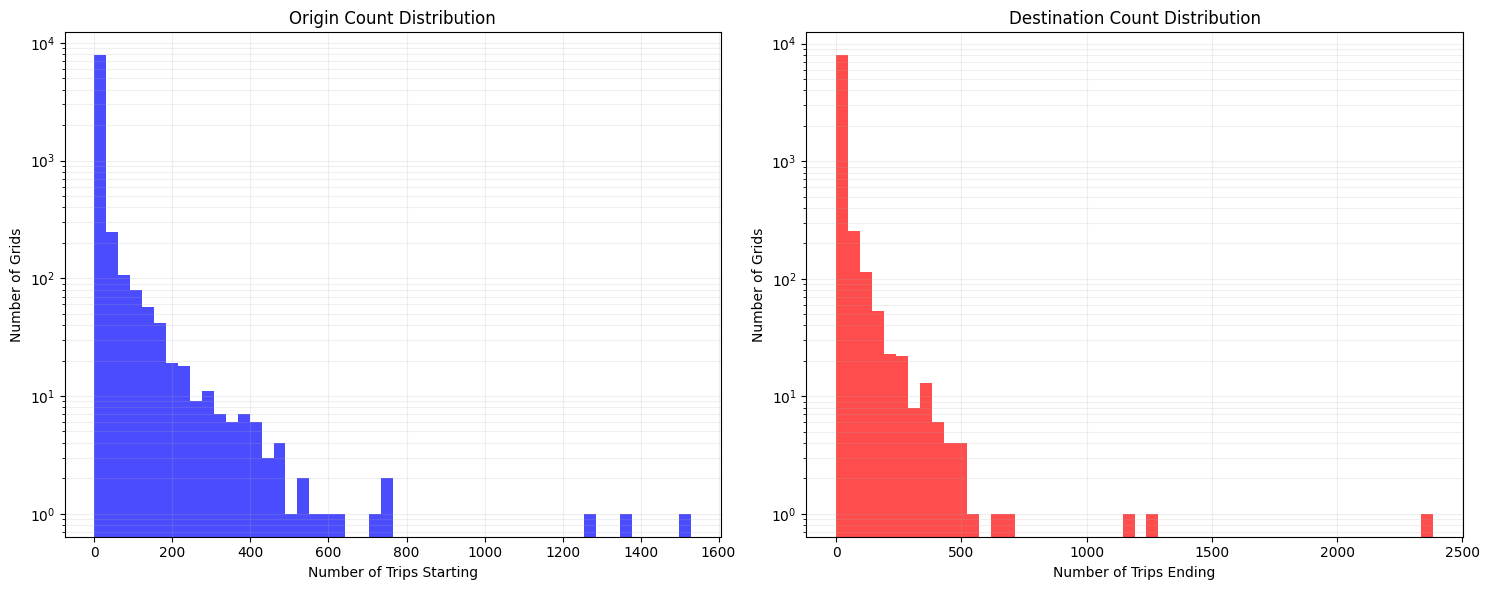

出行和到达次数分布图已保存到：data/grid/trip_distribution.png


In [12]:
import matplotlib.pyplot as plt

# 创建画布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 出行次数分布
ax1.hist(grid_stats['origin_count'], bins=50, color='blue', alpha=0.7)
ax1.set_title('Origin Count Distribution')
ax1.set_xlabel('Number of Trips Starting')
ax1.set_ylabel('Number of Grids')
ax1.set_yscale('log')  # 使用对数y轴
ax1.grid(True, which="both", ls="-", alpha=0.2)

# 到达次数分布
ax2.hist(grid_stats['dest_count'], bins=50, color='red', alpha=0.7)
ax2.set_title('Destination Count Distribution')
ax2.set_xlabel('Number of Trips Ending')
ax2.set_ylabel('Number of Grids')
ax2.set_yscale('log')  # 使用对数y轴
ax2.grid(True, which="both", ls="-", alpha=0.2)

# 调整布局
plt.tight_layout()

# 保存图像
plt.savefig('data/visualization/trip_distribution.png', dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

print("出行和到达次数分布图已保存到：data/grid/trip_distribution.png")

可以发现出租车单日轨迹数据的一大问题：数据往往仅覆盖部分区域（如市中心区域、交通枢纽等），导致空间划分的1km网格中部分网格无法被数据覆盖。直接忽略这些区域的流量会导致结果不完整，甚至扭曲对城市空间结构的理解（如低估偏远区域的出行需求）。

为了解决该问题，我们提出数据填补模型如下：
1. 赋予每个网格一个默认的“潜在出行”权重：对于未被出租车覆盖的网格（无数据），假设其出行活动依赖于邻近的空间关系；
2. 构建8-邻域关系：每个网格与其周围的8个邻域网格（上下左右及对角线方向）建立连接，每一对邻接的网格被赋予一个默认权重 0.125；
3. 总默认权重的平衡：每个网格会向其8个邻域各分配 0.125，最终每个网格的权重总和增加 1（等效于每个网格默认存在至少“1次潜在出行”）；

该模型可以表示为：
$$
\langle T_{ij} \rangle = \underbrace{\alpha \cdot T_{ij}^{\text{观测}}}_{\text{数据驱动部分}} + \underbrace{(1-\alpha) \cdot 0.125}_{\text{邻域填补部分}}
$$
此处$\alpha$为数据覆盖度权重参数：
* 当网格有出租车数据：$\alpha=1$，模型结果由实际数据主导；
* 当网格无出租车数据：$\alpha=0$，模型完全依赖邻域填补的0.125权重；

<!-- 我们基于数据分布特性设定动态调整参数 $\alpha$：
$$
\alpha = \min\left( \frac{n}{n_{\text{阈值}}} , 1 \right)
$$
其中，$n$为某网格的出行/到达次数。 -->

<!-- 关于阈值的确定，我们先观察数据分布的统计量： -->

In [13]:
# # 计算出行次数的统计量
# origin_stats = {
#     'mean': grid_stats['origin_count'].mean(),
#     '25%': grid_stats['origin_count'].quantile(0.25),
#     '50%': grid_stats['origin_count'].quantile(0.5),  # 中位数
#     '75%': grid_stats['origin_count'].quantile(0.75),
#     '95%': grid_stats['origin_count'].quantile(0.95),
#     'max': grid_stats['origin_count'].max()
# }

# # 计算到达次数的统计量
# dest_stats = {
#     'mean': grid_stats['dest_count'].mean(),
#     '25%': grid_stats['dest_count'].quantile(0.25),
#     '50%': grid_stats['dest_count'].quantile(0.5),  # 中位数
#     '75%': grid_stats['dest_count'].quantile(0.75),
#     '95%': grid_stats['dest_count'].quantile(0.95),
#     'max': grid_stats['dest_count'].max()
# }

# # 打印结果
# print("出行次数统计：")
# for key, value in origin_stats.items():
#     print(f"{key}: {value:.2f}")

# print("\n到达次数统计：")
# for key, value in dest_stats.items():
#     print(f"{key}: {value:.2f}")

# # 保存结果到文件
# stats_df = pd.DataFrame({
#     'origin_count': origin_stats,
#     'dest_count': dest_stats
# })
# stats_df.to_csv('data/grid/trip_statistics.csv', index=True)

# print("\n统计结果已保存到：data/grid/trip_statistics.csv")

In [14]:
import numpy as np


<!-- 我们选择$n_{\text{阈值}} = 3$ -->

In [15]:
def get_neighbor_grids(grid_id):
    """根据网格ID获取8邻域网格"""
    neighbors = []
    
    # 8邻域方向
    directions = [(-133,1), (0,1), (133,1),
                 (-133,0),          (133,0),
                 (-133,-1),  (0,-1), (133,-1)]
    
    for dx, dy in directions:
        neighbor_id = grid_id + dx + dy
        neighbors.append(neighbor_id)
    
    return neighbors

In [16]:
def fill_missing_data(grid_stats):
    """实现数据填补"""
    # 初始化填补后的数据
    filled_data = grid_stats.copy()
    
    # 添加新列
    filled_data['filled_origin'] = 0.0
    filled_data['filled_dest'] = 0.0
    
    # 遍历所有网格
    for grid_id in filled_data['grid_id']:
        # 获取当前网格的观测值
        origin_obs = filled_data.loc[filled_data['grid_id'] == grid_id, 'origin_count'].values[0]
        dest_obs = filled_data.loc[filled_data['grid_id'] == grid_id, 'dest_count'].values[0]
        
        # 计算α
        alpha_origin = 1.0 if origin_obs > 0 else 0.0
        alpha_dest = 1.0 if dest_obs > 0 else 0.0
        
        # 数据驱动部分
        data_driven_origin = alpha_origin * origin_obs
        data_driven_dest = alpha_dest * dest_obs
        
        # 邻域填补部分
        neighbor_fill_origin = 0.0
        neighbor_fill_dest = 0.0
        
        # 获取邻域网格
        neighbors = get_neighbor_grids(grid_id)
        for neighbor_id in neighbors:
            if neighbor_id in filled_data['grid_id'].values:
                neighbor_origin = filled_data.loc[filled_data['grid_id'] == neighbor_id, 'origin_count'].values[0]
                neighbor_dest = filled_data.loc[filled_data['grid_id'] == neighbor_id, 'dest_count'].values[0]
                
                neighbor_fill_origin += 0.125 * (1 - alpha_origin) * neighbor_origin
                neighbor_fill_dest += 0.125 * (1 - alpha_dest) * neighbor_dest
        
        # 计算填补后的值
        filled_data.loc[filled_data['grid_id'] == grid_id, 'filled_origin'] = data_driven_origin + neighbor_fill_origin
        filled_data.loc[filled_data['grid_id'] == grid_id, 'filled_dest'] = data_driven_dest + neighbor_fill_dest
    
    return filled_data

In [17]:
# 应用填补模型
filled_stats = fill_missing_data(grid_stats)

# 保存结果
filled_stats.to_csv('data/grid/filled_grid_stats.csv', index=False)

print("数据填补已完成，结果保存到：data/grid/filled_grid_stats.csv")

数据填补已完成，结果保存到：data/grid/filled_grid_stats.csv


In [18]:
# 创建对数颜色映射
max_filled = filled_stats['filled_dest'].max()
log_norm = cm.LinearColormap(
    ['yellow', 'orange', 'red'],
    vmin=-1,
    vmax=np.log1p(max_filled)  # 使用log1p避免log(0)
).to_step(10)

In [19]:
# 创建基础地图
m2 = folium.Map(location=shanghai_center, zoom_start=11)

# 添加网格和热度
for _, grid in filled_stats.iterrows():
    # 获取网格边界
    grid_info = grids_gdf.loc[grids_gdf['grid_id'] == grid['grid_id']]
    min_y = float(grid_info['min_y'].values[0])
    max_y = float(grid_info['max_y'].values[0])
    min_x = float(grid_info['min_x'].values[0])
    max_x = float(grid_info['max_x'].values[0])
    
    bounds = [(min_y, min_x), (max_y, max_x)]
    
    # 计算颜色（使用填补后的值）
    dest_value = grid['filled_dest']
    color = log_norm(np.log1p(dest_value))

    # 创建矩形
    folium.Rectangle(
        bounds=bounds,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        weight=1,
        tooltip=f"ID: {grid['grid_id']}, Destination: {dest_value}"
    ).add_to(m2)

# 添加颜色图例
log_norm.caption = 'Destination Count (log scale)'
m2.add_child(log_norm)

# 保存地图
m2.save('data/visualization/filled_grid_heatmap.html')

print("填补后的网格热度图已保存到：data/visualization/filled_grid_heatmap.html")
print("请在浏览器中打开该文件查看结果")

填补后的网格热度图已保存到：data/visualization/filled_grid_heatmap.html
请在浏览器中打开该文件查看结果


In [20]:
# 检查统计结果
print("\n统计结果验证：")
print(f"总起点次数: {filled_stats['filled_origin'].sum()}")
print(f"总终点次数: {filled_stats['filled_dest'].sum()}")


统计结果验证：
总起点次数: 95110.25
总终点次数: 95584.125


### 3.3 距离计算
我们将任意两个区域的距离定义为网格中心点的欧式距离。

In [25]:
from math import radians, cos, sin, sqrt, atan2

In [26]:
def haversine(lon1, lat1, lon2, lat2):
    """
    使用Haversine公式计算两个经纬度坐标之间的距离（单位：公里）
    """
    # 地球半径（公里）
    R = 6371.0
    
    # 将角度转换为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # 计算差值
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine公式
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c

In [27]:
# 计算网格中心点
grids_gdf['center_x'] = (grids_gdf['min_x'] + grids_gdf['max_x']) / 2
grids_gdf['center_y'] = (grids_gdf['min_y'] + grids_gdf['max_y']) / 2

# 获取所有网格ID和中心点坐标
grid_ids = grids_gdf['grid_id'].values
centers = grids_gdf[['center_x', 'center_y']].values

In [28]:
# 初始化距离矩阵
n_grids = len(grid_ids)
distance_matrix = np.zeros((n_grids, n_grids))

In [29]:
# 计算距离（单位：公里）
for i in range(n_grids):
    for j in range(n_grids):
        if i == j:
            distance_matrix[i, j] = 0  # 对角线为0
        else:
            # 计算两个中心点之间的距离
            distance_matrix[i, j] = haversine(
                centers[i, 0], centers[i, 1],  # 网格i的经度，纬度
                centers[j, 0], centers[j, 1]   # 网格j的经度，纬度
            )

# 将距离矩阵转换为DataFrame
distance_df = pd.DataFrame(distance_matrix, index=grid_ids, columns=grid_ids)

In [30]:
# 保存距离矩阵
distance_df.to_csv('data/grid/grid_distance_matrix.csv')

print("网格距离矩阵已保存到：data/grid/grid_distance_matrix.csv")
print("\n距离矩阵（前5x5）：")
print(distance_df.iloc[:5, :5])

网格距离矩阵已保存到：data/grid/grid_distance_matrix.csv

距离矩阵（前5x5）：
          6251      5852      6118      5985      5986
6251  0.000000  3.024332  1.009763  2.016754  2.225251
5852  3.024332  0.000000  2.016081  1.008070  1.409877
6118  1.009763  2.016081  0.000000  1.008021  1.421093
5985  2.016754  1.008070  1.008021  0.000000  0.996896
5986  2.225251  1.409877  1.421093  0.996896  0.000000


### 3.4 出行流量预测

In [35]:
def calculate_p_norm(filled_stats):
    """计算P_norm(i)"""
    total_origin = filled_stats['filled_origin'].sum()
    filled_stats['p_norm'] = filled_stats['filled_origin'] / total_origin
    return filled_stats

In [36]:
def calculate_m_i(filled_stats, distance_matrix, sigma=1.0):
    """计算M(i)"""
    n = len(filled_stats)
    dest_counts = filled_stats['filled_dest'].values
    
    # 创建一个掩码，排除对角线元素
    mask = ~np.eye(n, dtype=bool)
    
    # 计算距离衰减: 1/d^sigma
    distance_decay = np.zeros_like(distance_matrix)
    valid_distances = distance_matrix > 0
    distance_decay[valid_distances] = distance_matrix[valid_distances] ** (-sigma)

    # 对每行进行点积运算: sum(P(j)/d_ij^sigma)
    m_values = np.zeros(n)
    for i in range(n):
        m_values[i] = np.sum(dest_counts * distance_decay[i] * mask[i])
    
    filled_stats['m_i'] = m_values
    return filled_stats

In [37]:
def predict_traffic(filled_stats, distance_matrix, sigma=1.0):
    """
    预测出行流量
    :param filled_stats: 包含观测值的网格统计数据
    :param distance_matrix: 网格距离矩阵（公里）
    :param sigma: 距离衰减参数
    :return: 包含预测结果的DataFrame
    """
    # 计算P_norm
    filled_stats = calculate_p_norm(filled_stats)
    
    # 计算M(i)
    filled_stats = calculate_m_i(filled_stats, distance_matrix, sigma)
    
    # 总行程数
    T = filled_stats['filled_origin'].sum()
    
    # 初始化预测矩阵
    n = len(filled_stats)
    p_norm_values = filled_stats['p_norm'].values
    dest_counts = filled_stats['filled_dest'].values
    m_i_values = filled_stats['m_i'].values
    
    # 创建一个掩码，排除对角线元素
    mask = ~np.eye(n, dtype=bool)
    
    # 初始化预测矩阵
    predicted_matrix = np.zeros((n, n))
    
    # 计算距离衰减
    distance_decay = np.zeros_like(distance_matrix)
    valid_distances = distance_matrix > 0
    distance_decay[valid_distances] = distance_matrix[valid_distances] ** (-sigma)

    # 向量化计算预测矩阵
    for i in range(n):
        # 计算 (T/m_i) * p_norm_i * p_j / d_ij^sigma
        scale = (T / m_i_values[i]) * p_norm_values[i] if m_i_values[i] > 0 else 0
        predicted_matrix[i] = scale * dest_counts * distance_decay[i] * mask[i]
    
    # 将预测矩阵转换为DataFrame
    grid_ids = filled_stats['grid_id'].values
    predicted_df = pd.DataFrame(predicted_matrix, index=grid_ids, columns=grid_ids)
    
    return predicted_df

In [39]:
sigma = 1.0  # 距离衰减参数
predicted_traffic = predict_traffic(filled_stats, distance_matrix, sigma)

# 保存预测结果
predicted_traffic.to_csv('data/results/predicted_traffic_matrix.csv')

print("出行流量预测矩阵已保存到：data/results/predicted_traffic_matrix.csv")
print("\n预测矩阵（前5x5）：")
print(predicted_traffic.iloc[:5, :5].round(2))

出行流量预测矩阵已保存到：data/results/predicted_traffic_matrix.csv

预测矩阵（前5x5）：
      6251  5852  6118  5985  5986
6251   0.0   0.0   0.0   0.0   0.0
5852   0.0   0.0   0.0   0.0   0.0
6118   0.0   0.0   0.0   0.0   0.0
5985   0.0   0.0   0.0   0.0   0.0
5986   0.0   0.0   0.0   0.0   0.0


### 3.5 参数优化

In [40]:
from scipy.optimize import minimize

In [41]:
def calculate_negative_log_likelihood(sigma, filled_stats, distance_matrix, observed_matrix):
    """
    计算负对数似然
    :param sigma: 距离衰减参数
    :param filled_stats: 网格统计数据
    :param distance_matrix: 距离矩阵
    :param observed_matrix: 观测到的出行矩阵
    :return: 负对数似然值
    """
    # 获取预测值
    predicted_matrix = predict_traffic(filled_stats, distance_matrix, sigma).values
    
    # 计算负对数似然
    nll = 0
    n = len(filled_stats)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            t_ij = observed_matrix[i, j]
            if t_ij > 0:
                pred_ij = predicted_matrix[i, j]
                if pred_ij > 0:
                    nll -= t_ij * np.log(pred_ij)
    
    return nll

In [42]:
def optimize_sigma(filled_stats, distance_matrix, observed_matrix, sigma_init=1.0):
    """
    优化距离衰减参数sigma
    :param filled_stats: 网格统计数据
    :param distance_matrix: 距离矩阵
    :param observed_matrix: 观测到的出行矩阵
    :param sigma_init: sigma的初始值
    :return: 优化后的sigma值
    """
    # 定义优化函数
    def objective(sigma):
        return calculate_negative_log_likelihood(sigma[0], filled_stats, distance_matrix, observed_matrix)
    
    # 设置优化范围
    bounds = [(0.1, 2.0)]  # sigma的范围
    
    # 进行优化
    result = minimize(objective, [sigma_init], bounds=bounds, method='L-BFGS-B')
    
    return result.x[0]

In [44]:
# 准备观测矩阵
observed_matrix = np.zeros_like(distance_matrix)
for _, trip in final_trips.iterrows():
    origin_idx = np.where(filled_stats['grid_id'] == trip['origin_grid'])[0][0]
    dest_idx = np.where(filled_stats['grid_id'] == trip['dest_grid'])[0][0]
    observed_matrix[origin_idx, dest_idx] += 1

# 优化sigma
optimal_sigma = optimize_sigma(filled_stats, distance_matrix, observed_matrix)

print(f"优化后的距离衰减参数 sigma: {optimal_sigma:.4f}")

# 使用优化后的sigma重新预测
predicted_traffic_optimal = predict_traffic(filled_stats, distance_matrix, optimal_sigma)
predicted_traffic_optimal.to_csv('data/results/predicted_traffic_matrix_optimal.csv')

print("使用优化参数后的预测矩阵已保存到：data/results/predicted_traffic_matrix_optimal.csv")

KeyboardInterrupt: 